# Time Series Analysis Pt. 1
The purpose of this notebook is to explore the time series trends of the different renewable energy sources contained in the Spanish energy market dataset.
The structure is as follows:

- Time Series EDA
- Time Series Decomposition
- Benchmark forecasting model development with NeuralProphet's Auto-Regression Network

In the next notebook I will develop the model further to incorporate weather data for better predictive accuracy


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from collections import namedtuple
from src.data.make_dataset import *
from IPython.display import Image
from src.stattests import *
from src.models.train_model import *
from src.visualization.visualize import *
from neural_prophet.neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['axes.titlesize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['lines.linewidth'] = 2


In [2]:
energy_df = pd.read_csv('data/raw/energy_dataset.csv')  # Read in datasets
weather_df = pd.read_csv('data/raw/weather_features.csv')
weather_df.rename(columns={'dt_iso':'time'}, inplace=True)

In [3]:
weather_df = resample_dataframe(datetime_conversion(weather_df))

In [4]:
energy_df = resample_dataframe( # Perform pre-processing
    datetime_conversion(
        drop_absent_cols(energy_df)))

dropping column:  generation fossil coal-derived gas
dropping column:  generation fossil oil shale
dropping column:  generation fossil peat
dropping column:  generation geothermal
dropping column:  generation hydro pumped storage aggregated
dropping column:  generation marine
dropping column:  generation wind offshore
dropping column:  forecast wind offshore eday ahead


Text(0, 0.5, 'Power Generation (MW)')

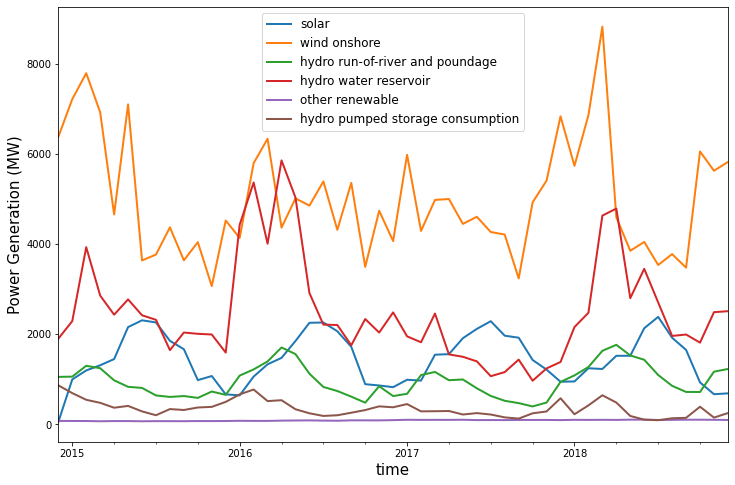

In [5]:
renewable_sources = ['solar', 'wind onshore', 'hydro run-of-river and poundage', 'hydro water reservoir', 'other renewable', 'hydro pumped storage consumption']
renewable_cols = ['generation ' + source for source in renewable_sources]
fossil_fuel_sources = ['fossil brown coal/lignite', 'fossil gas', 'fossil hard coal', 'fossil oil']
fossil_fuel_cols = ['generation ' + source for source in fossil_fuel_sources]
other_source = ['nuclear', 'other', 'waste', 'biomass']
other_cols = ['generation ' + source for source in other_source]

fig,ax = plt.subplots(figsize = (12,8))
for i, col in enumerate(renewable_cols):
     energy_df[col].resample('1m').median().plot(ax=ax, label = renewable_sources[i])
ax.legend()
ax.set_ylabel('Power Generation (MW)')

## Are the time series stationary? Is there an overall trend?

The augmented dicky fuller (adf) test tests for a unit root, and, while it cannot tell if the data is seasonal (in the case of this dataset), it can determine if there is a growing or decreasing trend in time. In all the power sources, the adf demonstrates that there is no overall increase or decrease in the series.

In [6]:
for i, col in enumerate(renewable_cols):
     adf_test(energy_df[col], renewable_sources[i])


Results of Dickey-Fuller Test for solar:
Test Statistic                   -5.018076
p-value                           0.000020
#Lags Used                       20.000000
Number of Observations Used    1441.000000
Critical Value (1%)              -3.434896
Critical Value (5%)              -2.863548
Critical Value (10%)             -2.567839
dtype: float64
Reject Null Hypothesis, Series is Stationary


Results of Dickey-Fuller Test for wind onshore:
Test Statistic                -1.256938e+01
p-value                        2.019879e-23
#Lags Used                     5.000000e+00
Number of Observations Used    1.456000e+03
Critical Value (1%)           -3.434849e+00
Critical Value (5%)           -2.863527e+00
Critical Value (10%)          -2.567828e+00
dtype: float64
Reject Null Hypothesis, Series is Stationary


Results of Dickey-Fuller Test for hydro run-of-river and poundage:
Test Statistic                   -3.375681
p-value                           0.011816
#Lags Used               

## Seasonal Decomposition

It can be useful to decompose time series into their respective components: overall trend, seasonal data and residual. Given that the DF tests performed showed that the time series are indeed stationary, we expect that the overall trend does not show an obvious growth or decay.

Results of D’Agostino and Pearson Test for generation solar:
p = 0.846122
null hyp: series comes from a normal distribution
The null hypothesis cannot be rejected
Results of D’Agostino and Pearson Test for generation wind onshore:
p = 0.544397
null hyp: series comes from a normal distribution
The null hypothesis cannot be rejected
Results of D’Agostino and Pearson Test for generation hydro run-of-river and poundage:
p = 0.633413
null hyp: series comes from a normal distribution
The null hypothesis cannot be rejected
Results of D’Agostino and Pearson Test for generation hydro water reservoir:
p = 0.146521
null hyp: series comes from a normal distribution
The null hypothesis cannot be rejected


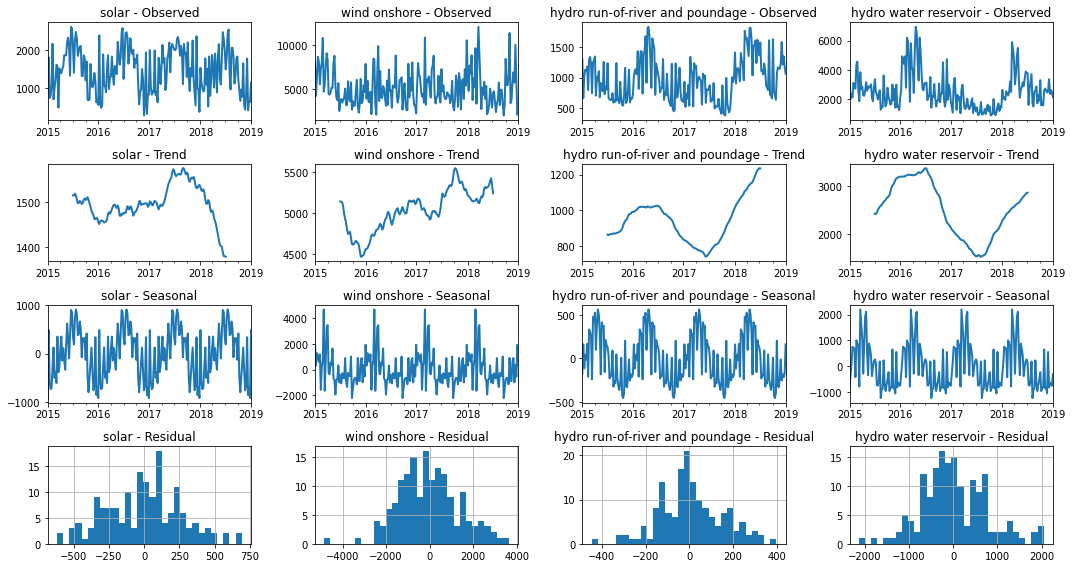

In [7]:
important_renewable_sources = renewable_cols[:4]

# Create dictionary for the period of seasonal decomposition given resample rate
time_dict = {'1d':365, '1w':52, '2w':26, '1m':12}  
def time_series_decomposition(resample_rate='1m'):  # Choose the frequency of the resample
    fig,ax = plt.subplots(4, 4, figsize=(15, 8))
    for i, source in enumerate(important_renewable_sources):
        # print(source)
        result = seasonal_decompose(energy_df[source].resample(resample_rate).median(), period = time_dict[resample_rate])
        result.observed.plot(ax=ax[0,i])
        ax[0,i].set_title(renewable_sources[i] + ' - Observed')
        result.trend.plot(ax=ax[1,i])
        ax[1,i].set_title(renewable_sources[i] + ' - Trend')
        result.seasonal.plot(ax=ax[2,i])
        ax[2,i].set_title(renewable_sources[i] + ' - Seasonal')
        result.resid.hist(ax=ax[3,i], bins=30)
        ax[3,i].set_title(renewable_sources[i] + ' - Residual')
        for j in range(4):
            ax[j,i].set_xlabel('')
        normal_test(result.resid, important_renewable_sources[i])
    fig.tight_layout()

time_series_decomposition('1w')  # Changing the resampling rate can help to discern different trends


For the seasonal decomposition to work we expect that the residual is normally distributed, a D’Agostino and Pearson normal test i sapplied on the residuals to test how well they conform to a normal distribution.

As shown below, once seasonal differences are accounted for, the trends are stationary

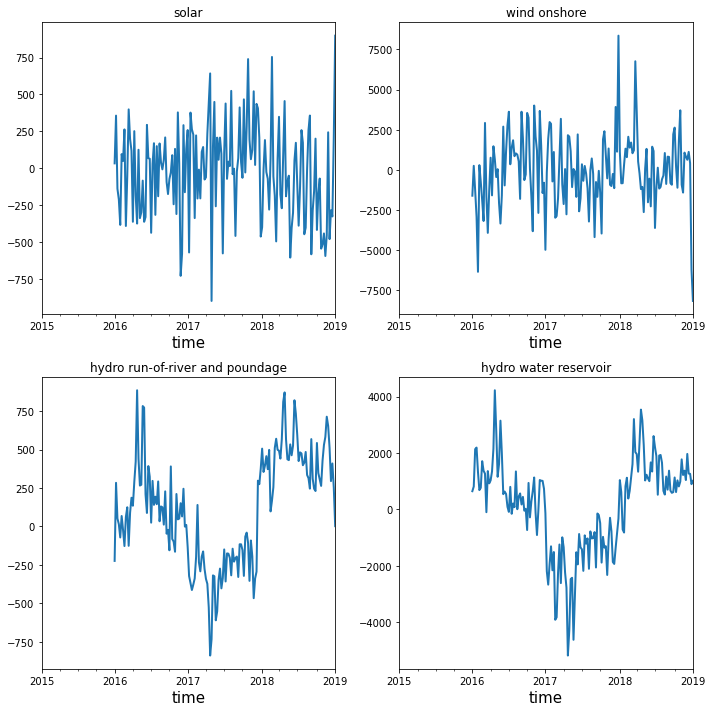

In [8]:
def seasonal_difference_plot(timeseries, ax):
    series = timeseries - timeseries.shift(365)
    series.resample('1w').mean().plot(ax=ax)
    return series
fig, ax = plt.subplots(2, 2, figsize=(10,10))
axs = ax.ravel()

for i, source in enumerate(important_renewable_sources):
    energy_df['seasonal difference - ' +renewable_sources[i]] = seasonal_difference_plot(energy_df[source], axs[i])
    axs[i].set_title(renewable_sources[i])
fig.tight_layout()

## Autocorrelation Plots

### AR - Autoregression

\begin{equation}
y_i = c + \sum_{i=1}^{p}\varphi_i y_{t-1} + \varepsilon_t

\end{equation}

 - The simplest AR model assumes each step in the series is correlated with previous timesteps.
 - An partial autocorrelation plot will help to uncover this trend

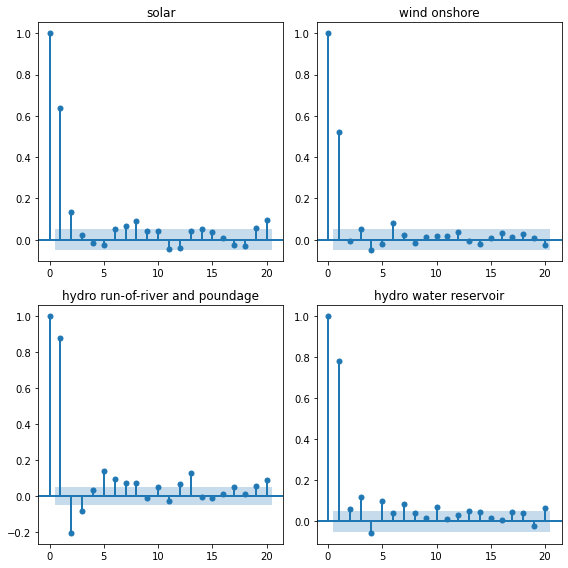

In [9]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
axs = ax.ravel()
for i, source in enumerate(important_renewable_sources):
    plot_pacf(energy_df[important_renewable_sources[i]], lags=20, ax=axs[i])
    axs[i].set_title(renewable_sources[i])
fig.tight_layout()

## Establishing a Benchmark Model with Neural Prophet

To begin building models of energy production, I establish a baseline:
 - The baseline model will not use any information about the weather but will draw only from previous time histories of the energy demand to forecast the next day.
 - For this analysis I will be using NeuralPhophet, a time series forecasting package developed by Facebook.
   - Within Neural Prophet I will be using AR-Net which is an autoregressive neural network
   - Integral to this process is specifying n_lags and n_forecasts. n_lags tells us how many previous days the model will use to forecast the next n_forecast days. 
   - To explore different models I will look at using n_lags=30 to predict 1 day ahead (n_forecast =1)
   - For each model I will use cross_validation to confirm their performance

It should be noted that the neural prophet package is limited in that it only allows for autoregression, as I incorporate other weather data I will need to use different models

First I experiment with solar:


In [10]:
important_renewable_sources

['generation solar',
 'generation wind onshore',
 'generation hydro run-of-river and poundage',
 'generation hydro water reservoir']

### Hyperparameter Tuning:

Looking at solar, I will explore the performance of the model with different hidden layer numbers, I want to see just how well the models can perform to set a reasonable benchmark.

 90%|█████████ | 228/253 [00:11<00:01, 20.33it/s]
train MAE: [335.6664066547707]
val MAE: [433.274658203125]
train MAE (avg): 335.6664066547707
val MAE (avg): 433.274658203125
 93%|█████████▎| 236/253 [00:09<00:00, 23.61it/s]
train MAE: [222.1023347065711]
val MAE: [476.62017822265625]
train MAE (avg): 222.1023347065711
val MAE (avg): 476.62017822265625
 ---- running exp: num. hidden layers = 6 (len: 1462) ----
 83%|████████▎ | 210/253 [00:10<00:02, 20.41it/s]
train MAE: [494.83554535178405]
val MAE: [529.6685180664062]
train MAE (avg): 494.83554535178405
val MAE (avg): 529.6685180664062


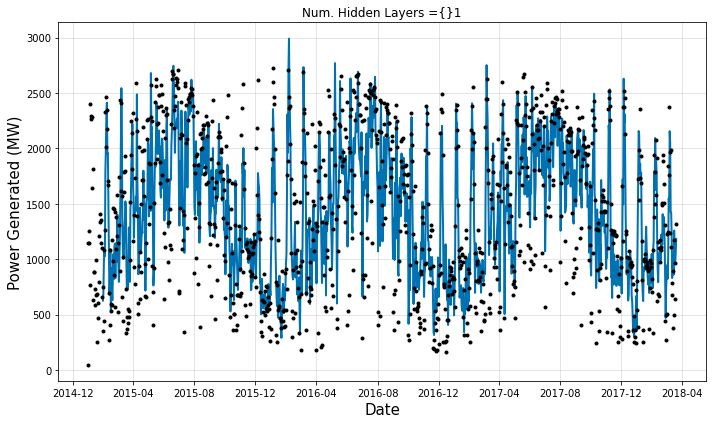

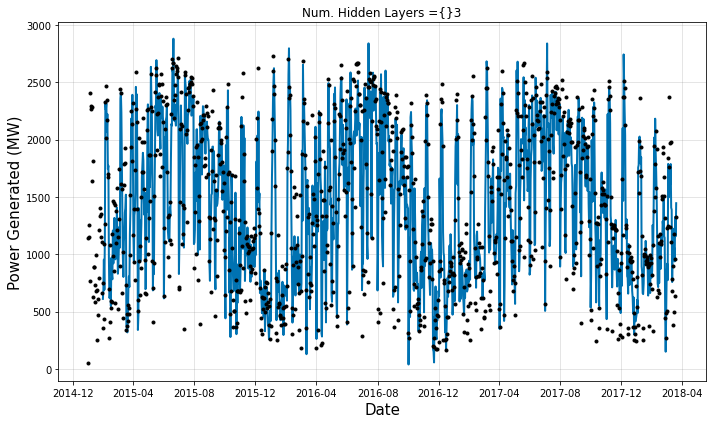

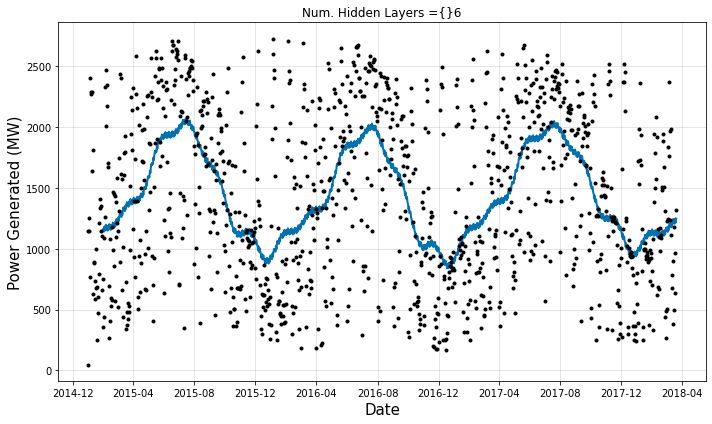

In [20]:
Experiment = namedtuple('Experiment', ['df', 'column_name', 'model_config'])
experiments = [
    Experiment(
        df=energy_df,
        column_name='generation solar',
        model_config={"n_lags": 30, 
                      "n_forecasts": 1,
                      "num_hidden_layers": 1,
                      "epochs":230},
    ),
    Experiment(
        df=energy_df,
        column_name='generation solar',
        model_config={"n_lags": 30, 
                      "n_forecasts": 1,
                      "num_hidden_layers": 3,
                      "epochs":230},
    ),
    Experiment(
        df=energy_df,
        column_name='generation solar',
        model_config={"n_lags": 30, 
                      "n_forecasts": 1,
                      "num_hidden_layers": 6,
                      "epochs":230},
    ),
]

for exp in experiments:
    fig, ax = plt.subplots(figsize=(10, 6))
    run_experiment(exp, k=1, ax=ax, 
                   title='num. hidden layers = {}'.format(exp.model_config['num_hidden_layers']), 
                   plot=True)
    ax.set_ylabel('Power Generated (MW)')
    ax.set_xlabel('Date')
    ax.set_title('Num. Hidden Layers ={}' + str(exp.model_config['num_hidden_layers']))
    fig.tight_layout()

Observations:
- quite high variation in performance across the folds which is not ideal
- is clear that there is a happy medium for the number of hidden layers in the network, too small and the model cannot capture the complexities of the data, too large and the model fails to converge accurately (why is this???).
I will choose a value of 3 hidden_layers

 ---- running exp: Test on = generation solar (len: 1462) ----
 94%|█████████▍| 239/253 [00:10<00:00, 21.92it/s]
train MAE: [272.8631821743278, 495.4020315439913]
val MAE: [357.8097839355469, 511.60101318359375]
train MAE (avg): 384.1326068591595
val MAE (avg): 434.7053985595703
 81%|████████  | 204/253 [00:07<00:01, 28.48it/s]
train MAE: [2250.3839650708574, 1191.1543320261371]
val MAE: [2251.32861328125, 2851.0185546875]
train MAE (avg): 1720.7691485484972
val MAE (avg): 2551.173583984375
 95%|█████████▍| 240/253 [00:07<00:00, 30.03it/s]
train MAE: [54.347956280375634, 55.812770803561385]
val MAE: [131.2400360107422, 160.3995819091797]
train MAE (avg): 55.08036354196851
val MAE (avg): 145.81980895996094
 92%|█████████▏| 232/253 [00:07<00:00, 31.46it/s]
train MAE: [354.52150268554686, 451.33687662121304]
val MAE: [1186.4703369140625, 628.1411743164062]
train MAE (avg): 402.9291896533799
val MAE (avg): 907.3057556152344


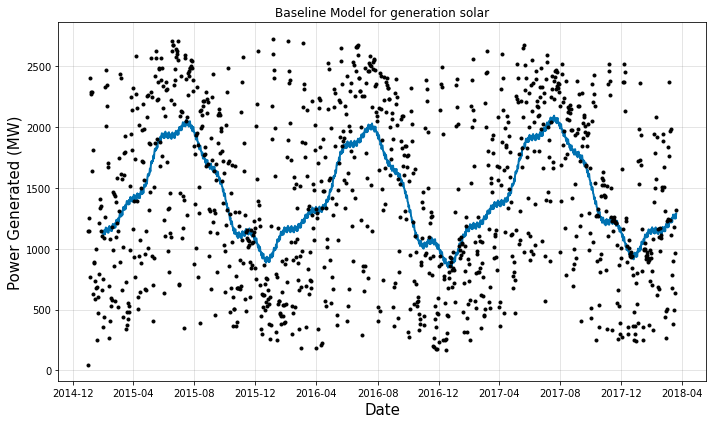

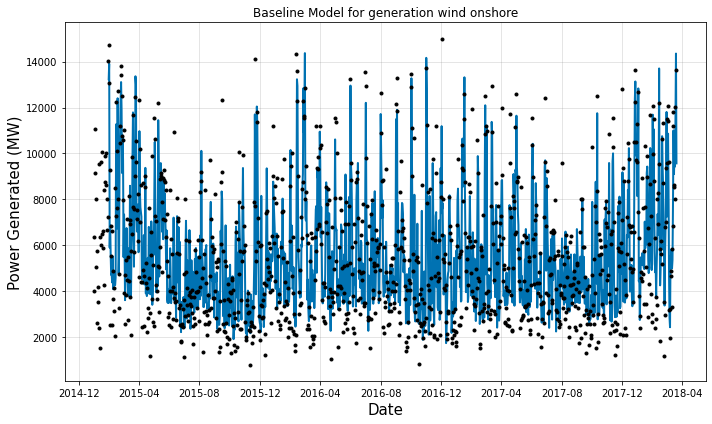

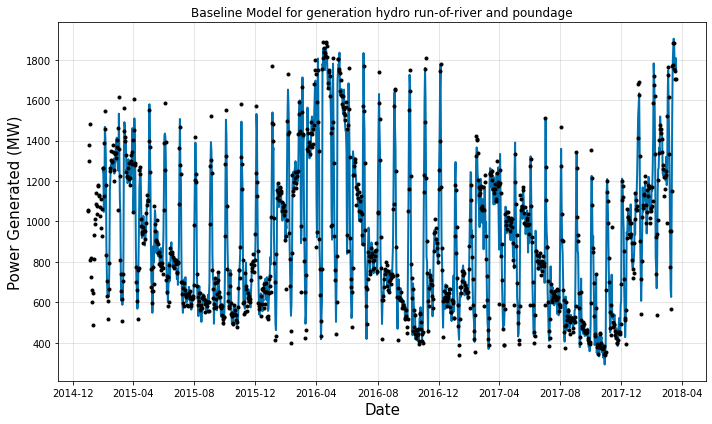

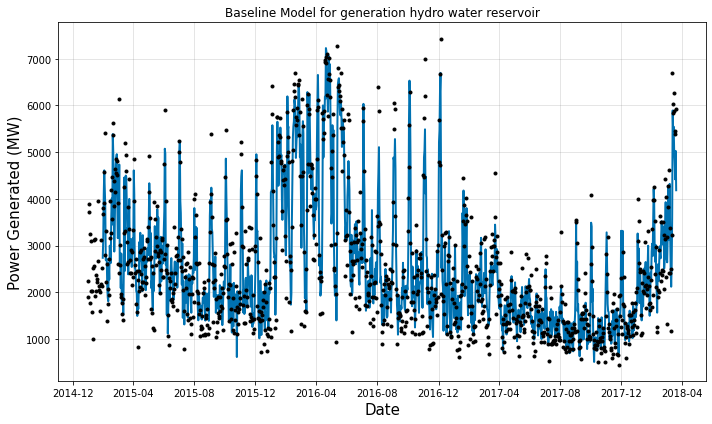

In [18]:
Experiment = namedtuple('Experiment', ['df', 'column_name', 'model_config'])
experiments = [
    Experiment(
        df=energy_df,
        column_name='generation solar',
        model_config={"n_lags": 30, 
                      "n_forecasts": 1,
                      "num_hidden_layers": 3,
                      "batch_size":128},
    ),
    Experiment(
        df=energy_df,
        column_name='generation wind onshore',
        model_config={"n_lags": 30, 
                      "n_forecasts": 1,
                      "num_hidden_layers": 3,
                      "batch_size":64},
    ),
    Experiment(
        df=energy_df,
        column_name='generation hydro run-of-river and poundage',
        model_config={"n_lags": 30, 
                      "n_forecasts": 1,
                      "num_hidden_layers": 3,
                      "batch_size":64},
    ),
    Experiment(
    df=energy_df,
    column_name='generation hydro water reservoir',
    model_config={"n_lags": 30, 
                    "n_forecasts": 1,
                    "num_hidden_layers": 3,
                    "batch_size": 64},
    ),
]


for exp in experiments:
    fig, ax = plt.subplots(figsize=(10, 6))
    path = os.path.join(".","reports","figures","baseline_models","baseline_model_{}.png".format(exp.column_name.replace(' ', '_')))

    run_experiment(exp, k=2, ax=ax, title='Test on = {}'.format(exp.column_name), plot=True)
    ax.set_ylabel('Power Generated (MW)')
    ax.set_xlabel('Date')
    ax.set_title('Baseline Model for ' + exp.column_name)
    fig.tight_layout()
    plt.savefig(path, transparent=True, dpi=100)

Now we have the benchmark models developed with the following metrics:
- solar
    - train MAE = 300
    - val MAE = 521.9
- wind power 
    - train MAE = 1871
    - val MAE = 2560
- hydro run-of-river and poundage
    - train MAE = 168.6
    - val MAE = 340
- hydro water reservoir
    - train MAE = 250
    - val MAE = 934 (potential overfitting??)

Observations:
    - hydro water reservoir shows spikes once every month, perhaps water gets let out and predetermined intervals 
    


Neural Prophet is very effective at predicting a few weather patterns such as temperature.

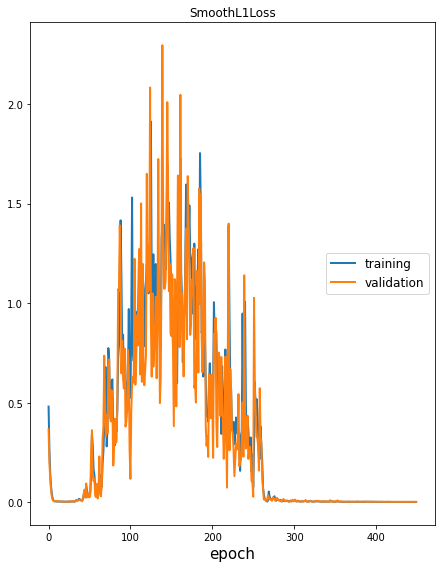

In [19]:
epochs = 450
plot_live_loss = True
valid_p=0.3
weather_metric='temp'
time_series = create_time_series(weather_df, weather_metric)

model = NeuralProphet(
     n_forecasts=5,
     n_lags=30,
     n_changepoints=0,
     yearly_seasonality=True,
     weekly_seasonality=False,
     daily_seasonality=False,
     batch_size=64,
     learning_rate=1)

metrics = model.fit(
    time_series,
    validate_each_epoch=True,
    valid_p=valid_p,
    freq='D',
    plot_live_loss=plot_live_loss,
    epochs=epochs)

SmoothL1Loss = 0.0019464046195048536
MAE = 1.3397054440279303
MSE = 2.9888917598705236
RegLoss = 0.0
SmoothL1Loss_val = 0.0025842306204140186
MAE_val = 1.526079773902893
MSE_val = 3.9683377742767334


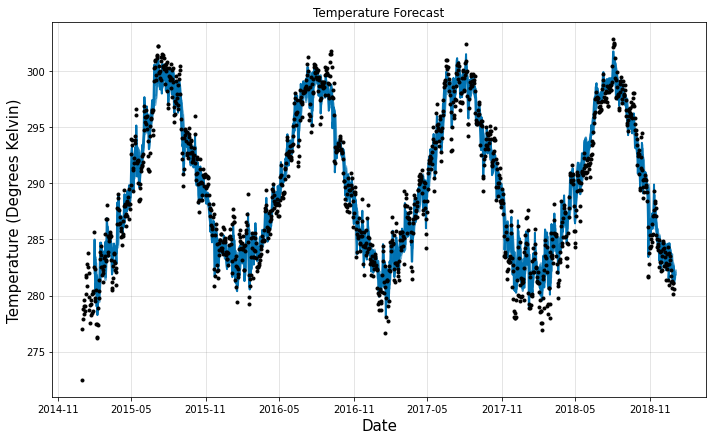

In [20]:
fig, ax = plt.subplots(figsize= (10,6))
plot_forecast(model, time_series, 1,
              ax=ax,
              historic_pred=True,
              highlight_steps_ahead=None)
ax.set_title('Temperature Forecast')
ax.set_ylabel('Temperature (Degrees Kelvin)')
for name in metrics.iloc[-1, :].index:
    print('{} = {}'.format(name, metrics.iloc[-1,:][name]))

path = os.path.join(".","reports","figures","baseline_models","Temperature_Forecast.png")
plt.savefig(path, transparent=True, dpi=100)